In [76]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import time as timess
import math, cmath
import sys; import time as time
import auxiliary_library as me

ts1 = np.linspace(0, 50, 750)

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, formatter={"float":lambda x: str(.001*int(1000*x)) })

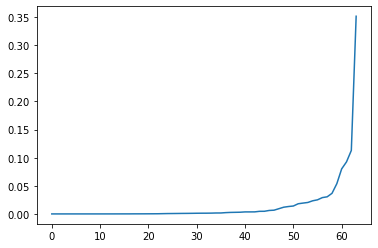

In [93]:
plt.plot(sorted(linalg.eig(rho0)[0].real))

In [89]:
min(linalg.eig(H_H)[0].real)### H-eig_max * id

-8.536807975127383

In [157]:
N = 8
spin_ops_list = me.one_body_spin_ops(N)

### Heisenberg Hamiltonian
chain_type = "XXX"; Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

### Basis operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
identity_op = spin_ops_list[0][0]

label_ops.append("magnetization"); label_ops.append("Neel_op"); 
cl_ops[label_ops[6]] = magnetization; cl_ops[label_ops[7]] = neel_operator; 

print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))
cl_ops = me.Hamiltonian_comm_check(H_H, cl_ops, None, True)
cl_ops["identity"] = identity_op

# Note that this is not the initial state but, ideally, the final state. 

k_B = 1; temp = 5.; x = .5
beta = 1/(k_B * temp)
K = -beta * (1-x) * H_H - x * (cl_ops["n_oc_op"] - 1)**2
Kmax = max(linalg.eigvals(K).real)
K = K - Kmax*identity_op
rho_ref = (K).expm()
rho_ref = rho_ref/rho_ref.tr()

if (me.is_density_op(rho_ref)):
    pass
else:
    sys.exit("Not a valid density op")

### Chosen basis and operators ### ops=[id_glob, n_oc, n_oc**2, x, p , ac, comm, corr, H]

basis = [cl_ops["identity"], cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2, cl_ops["x_op"], 
         cl_ops["p_op"], cl_ops["p_dot"], cl_ops["comm_xp"], cl_ops["corr_xp"],
         cl_ops["Neel_op"], H_H]

basis_orth = me.base_orth(basis, rho_ref, me.HS_inner_prod_r, False)

### Evolution 
#phi0 = [0., .1, .1, 2., 1., -1., 1, .1, -2., .1]
phi0 = [0] + [np.random.rand() for i in range(len(basis_orth)-1)]
rho0 = (-sum( f*op for f,op in zip(phi0, basis_orth))).expm()
phi0[0] = np.log(rho0.tr())
rho0 = (-sum( f*op for f,op in zip(phi0, basis_orth))).expm()

if (me.is_density_op(rho0)):
    pass
else:
    sys.exit("Not a valid density op")

Are all the operators Hermitian?: True
[H,  x_op ] = 0?:  False
[H,  p_op ] = 0?:  False
[H,  n_oc_op ] = 0?:  False
[H,  comm_xp ] = 0?:  False
[H,  corr_xp ] = 0?:  False
[H,  p_dot ] = 0?:  False
[H,  magnetization ] = 0?:  True
magnetization basis element deleted
[H,  Neel_op ] = 0?:  False


10 0.1


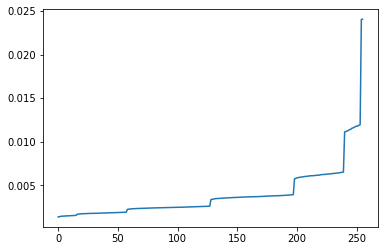

In [155]:
k_B = 1
temp = 10
x = .5
beta = 1/(k_B * temp)
print(temp,beta)
K = -beta *( (1-x) * H_H - x * (cl_ops["n_oc_op"] - 1)**2)
Kmax = max(linalg.eigvals(K).real)
K = K - Kmax*identity_op
rho_ref = (K).expm()
rho_ref = rho_ref/rho_ref.tr()


plt.plot(sorted(linalg.eigvals(rho_ref).real)) ### 

In [94]:
for i in range(len(basis_orth)):
    print("<Op[",i, "] rho0> ", qutip.expect(basis_orth[i], rho_ref))

<Op[ 0 ] rho0>  1.0
<Op[ 1 ] rho0>  -2.2898349882893854e-16
<Op[ 2 ] rho0>  -1.887379141862766e-15
<Op[ 3 ] rho0>  2.7755575615628914e-17
<Op[ 4 ] rho0>  0.0
<Op[ 5 ] rho0>  -8.673617379884035e-18
<Op[ 6 ] rho0>  0.0
<Op[ 7 ] rho0>  -7.589415207398531e-18
<Op[ 8 ] rho0>  1.3530843112619095e-16
<Op[ 9 ] rho0>  -2.8150225206413637e-15


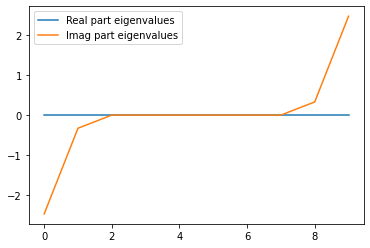

In [6]:
Hijtensor = np.array(me.H_ij_matrix(H_H, basis_orth, rho_ref, me.HS_inner_prod_r)[1])
plt.plot(qutip.Qobj(Hijtensor).eigenenergies().real, label = "Real part eigenvalues")
plt.plot(sorted(qutip.Qobj(Hijtensor).eigenenergies().imag), label = "Imag part eigenvalues")

plt.legend()

# Exact solution using semigroups

In [73]:
#ts1 = np.linspace(0, 50, 750)
Phi_vector_solution = []
Phi_vector_solution.append(np.array(phi0))

for i in range(len(ts1)-1):
    a = ( ts1[i+1] * qutip.Qobj(Hijtensor) ).expm() * Phi_vector_solution[0]
    Phi_vector_solution.append(a)
    
rho_at_timet = []
rho_at_timet.append(rho0)

for i in range(len(Phi_vector_solution)):
    rhot= (-sum( f*op for f,op in zip(Phi_vector_solution[i], basis_orth))).expm()
    rhot = rhot/rhot.tr()
    rho_at_timet.append(rhot)

for t in range(len(rho_at_timet)):
    if not me.is_density_op(rho_at_timet[t]):
        print("At time", t, "not density op")
        #rho_at_timet[t] = .5 * (rho_at_timet[t] + rho_at_timet[t].dag())
        #print("Moddified accordingly")

At time 105 not density op
At time 106 not density op
At time 107 not density op
At time 108 not density op
At time 109 not density op
At time 110 not density op
At time 111 not density op
At time 112 not density op
At time 113 not density op
At time 114 not density op
At time 115 not density op
At time 116 not density op
At time 117 not density op
At time 118 not density op
At time 119 not density op
At time 120 not density op
At time 121 not density op
At time 122 not density op
At time 123 not density op
At time 124 not density op
At time 125 not density op
At time 126 not density op
At time 127 not density op
At time 128 not density op
At time 129 not density op
At time 130 not density op
At time 131 not density op
At time 132 not density op
At time 133 not density op
At time 134 not density op
At time 135 not density op
At time 136 not density op
At time 137 not density op
At time 138 not density op
At time 139 not density op
At time 140 not density op
At time 141 not density op
A

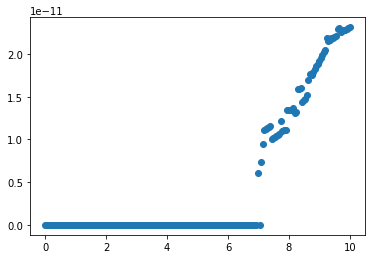

In [48]:
non_densitiness = []
for i in range(len(rho_at_timet)-1):
    non_densitiness.append(linalg.norm(linalg.norm(rho_at_timet[i] - rho_at_timet[i].dag())/(linalg.norm(rho_at_timet[i]))))
    
plt.scatter(ts1, non_densitiness)

In [49]:
basis = [cl_ops["identity"], cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2, cl_ops["x_op"], cl_ops["p_op"], 
         cl_ops["p_dot"], cl_ops["comm_xp"], cl_ops["corr_xp"], cl_ops["Neel_op"], H_H]

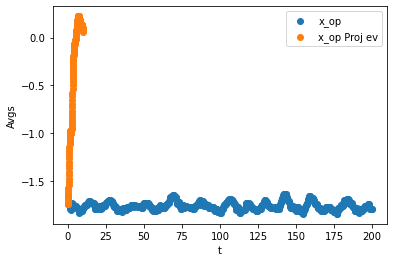

In [50]:
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis[3])
plt.scatter(res.times, res.expect[0], label = "x_op")

plt.scatter(ts1, (qutip.expect(cl_ops["x_op"], rho_at_timet)[:-1]), label = "x_op Proj ev")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

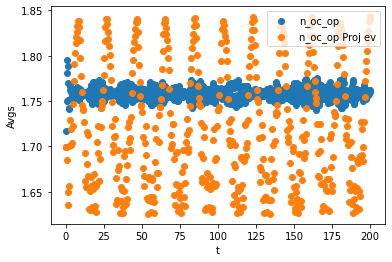

In [36]:
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis[1])
plt.scatter(res.times, res.expect[0], label = "n_oc_op")

plt.scatter(ts1, (qutip.expect(cl_ops["n_oc_op"], rho_at_timet)[:-1]), label = "n_oc_op Proj ev")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

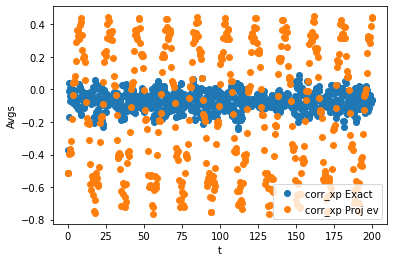

In [34]:
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis[7])
plt.scatter(res.times, res.expect[0], label = "corr_xp Exact")

plt.scatter(ts1, (qutip.expect(cl_ops["corr_xp"], rho_at_timet)[:-1]), label = "corr_xp Proj ev")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

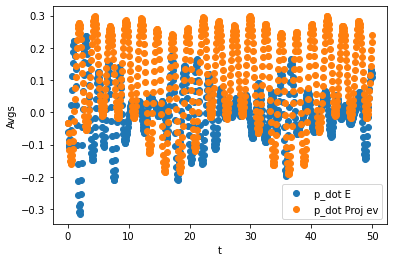

In [56]:

res=qutip.mesolve(H_H, rho0, ts1, c_ops=None, e_ops=basis[5])
plt.scatter(res.times, res.expect[0], label = "p_dot E")
plt.scatter(ts1, (qutip.expect(cl_ops["p_dot"], rho_at_timet)[:-1]), label = "p_dot Proj ev")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

/home/tomas/.conda/envs/qutip/lib/python3.10/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


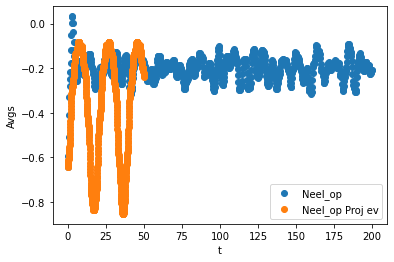

In [74]:
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis[8])
plt.scatter(res.times, res.expect[0], label = "Neel_op")

plt.scatter(ts1, (qutip.expect(cl_ops["Neel_op"], rho_at_timet)[:-1]), label = "Neel_op Proj ev")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()


# Entropía

### 

In [79]:
len(ts1)

750

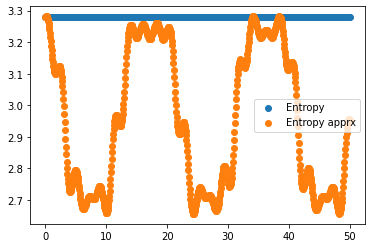

In [82]:
res=qutip.mesolve(H_H, rho0, ts1, c_ops=None, e_ops=None)
plt.scatter(ts1, [qutip.entropy_vn(rho) for rho in res.states], label = "Entropy")

plt.scatter(ts1, [qutip.entropy_vn(rho) for rho in rho_at_timet[:-1]], label = "Entropy apprx")
plt.legend()


In [40]:

res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=cl_ops("magnetization"))
plt.scatter(res.times, res.expect[0], label = "Mz")

plt.scatter(ts1, (qutip.expect(cl_ops["magnetization"], rho_at_timet)[:-1]), label = "Mz Proj ev")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

TypeError: 'dict' object is not callable

In [11]:
me.bures(rho_ref, rho0)

0.18928766458538204

In [12]:
#me.bures(rho_ref, rho_at_timet[500])
#rho_ref = (-.1 * H_H -.9 * (cl_ops["n_oc_op"] - cl_ops["Neel_op"])**2).expm()# .5*(cl_ops["n_oc_op"])**2).expm()


# Numerical Solution with ODEINT

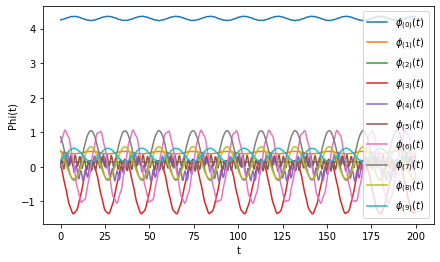

In [13]:
from scipy.integrate import odeint
import random

def F(y, t, H_tensor):
    return H_tensor.dot(y)

ts1 = np.linspace(0, 200, 500)
result = odeint(func=F, y0=phi0,t=ts1,args=(np.real(Hijtensor),))
plt.figure(figsize=(7, 4))

for i in range(len(basis)):
    plt.plot(ts1, result[:,i], label=r'$\phi_{(%d)}(t)$'%i)

plt.xlabel("t")
plt.ylabel("Phi(t)")
plt.legend()

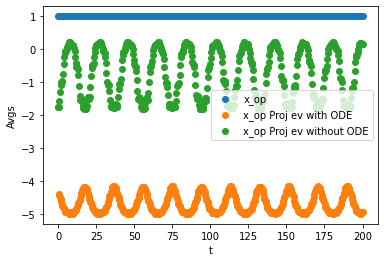

In [14]:
rho_at_timet_exact_ode = [rho0]

for t in range(len(ts1)):
    loc_K = sum([result[:,i][t] * basis_orth[i] for i in range(len(basis_orth))])
    rhot = (loc_K).expm()
    rhot = rhot/rhot.tr()
    rho_at_timet_exact_ode.append(rhot)
    loc_K = 0
    
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis)
for index, name in enumerate(["x_op"]):
    plt.scatter(res.times, res.expect[index], label = name)

plt.scatter(ts1, (qutip.expect(cl_ops["x_op"], rho_at_timet_exact_ode )[:-1]), label = "x_op Proj ev with ODE")
plt.scatter(ts1, (qutip.expect(cl_ops["x_op"], rho_at_timet)[:-1]), label = "x_op Proj ev without ODE")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

# Spin chain exact evolution 

In [15]:
start_time = time.time()
unitary_ev = True; gamma = None; size = N; gaussian = None; gr = None; xng = None
chain_types = "XXX"; Hamiltonian_paras = [.2, .15, .1, 1.]
obs_basis = basis; ts = np.linspace(0,200,850)

title, ev_paras, resultsB = me.spin_chain_ev(closed_bcs = True, size = size, init_state = rho0, chain_type = chain_types, 
                                             Hamiltonian_paras = Hamiltonian_paras, omega_1=3., omega_2=3., 
                                             temp=1, tmax = 200, deltat = 1, two_body_basis = True, 
                                             unitary_ev = unitary_ev, gamma = gamma, gaussian = gaussian, 
                                             gr = gr, xng = xng, sc_prod = me.HS_inner_prod_r, obs_basis = basis, 
                                             do_project = False)

print("--- %s seconds ---" % (time.time() - start_time))

ev_paras["Time elapsed"] = time.time() - start_time

Processing custom initial state
Processing custom observable basis
sampling: 30
Closed evolution chosen
--- 3.668121814727783 seconds ---


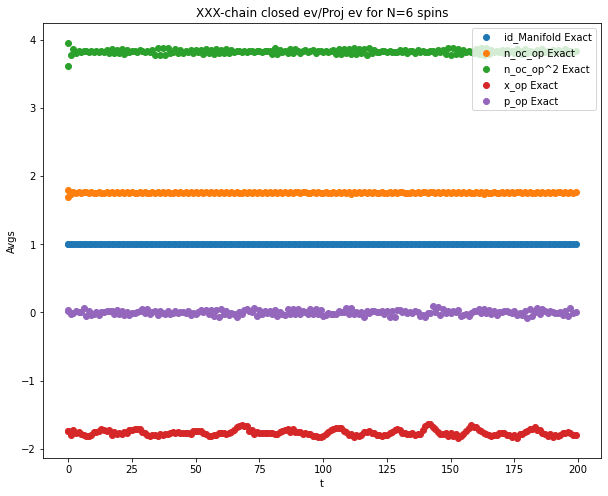

In [16]:
plot_labels1 = ["id_Manifold", "n_oc_op", "n_oc_op^2", "x_op", "p_op"] 
plot_labels2 = ["p_dot", "comm_xp", "corr_xp", "Neel_op", "H"]

plt.figure(figsize=(10, 8))

for n in range(len(plot_labels1)):
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n], label=plot_labels1[n] + " Exact")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

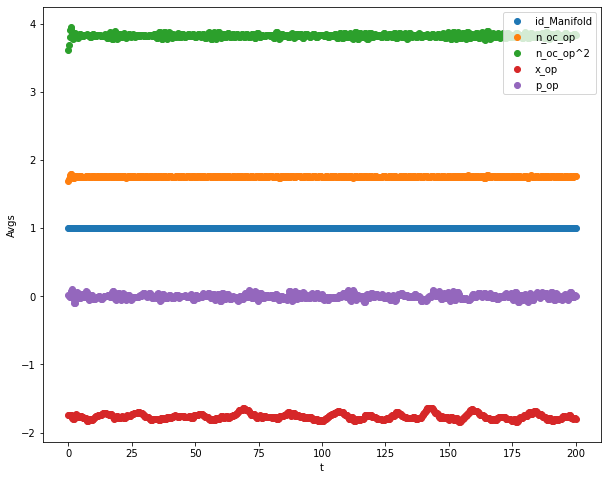

In [17]:
### dinÃƒÂ¡mica 

res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis)
plt.figure(figsize=(10, 8))

for index, name in enumerate(["id_Manifold", "n_oc_op", "n_oc_op^2", "x_op", "p_op"]): #+ ["p_dot", "comm_xp", "corr_xp", "Neel_op","H"]):
    plt.scatter(res.times, res.expect[index], label = name)
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()


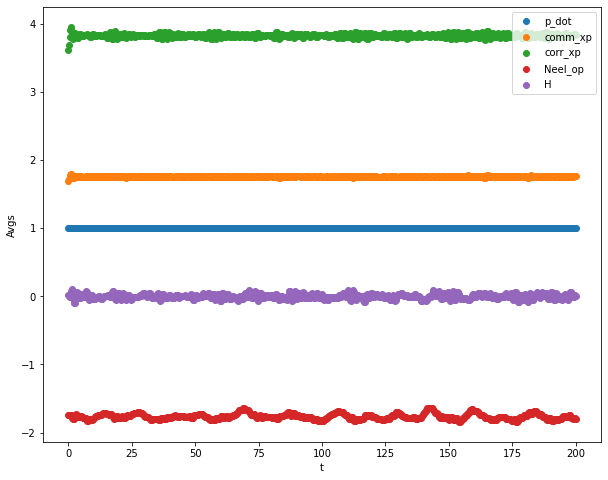

In [18]:
### dinÃƒÂ¡mica 

res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis)
plt.figure(figsize=(10, 8))

for index, name in enumerate(["p_dot", "comm_xp", "corr_xp", "Neel_op","H"]):
    plt.scatter(res.times, res.expect[index], label = name)
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

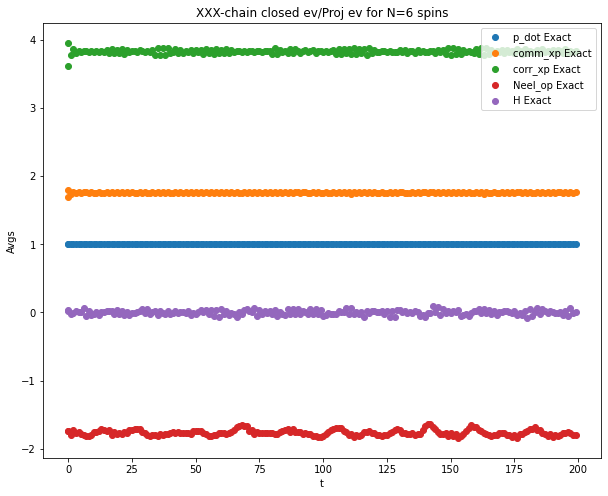

In [19]:
plt.figure(figsize=(10, 8))

for n in range(len(plot_labels2)):
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n], label=plot_labels2[n] + " Exact")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

In [ ]:
nabla_t = [[0, -1, 1, 0, 0, 0], [-1, 0, 1, 0, 0, 0], [-1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, -1], [0,0,0, 1, 0, -1], [0,0,0, 1, -1, 0]]
qutip.Qobj(qutip.Qobj(nabla_t).eigenenergies())